In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
from tqdm import tqdm 
import torch.nn as nn
import pandas as pd
import numpy as np
import random
import torch
import glob
import time
import copy
import os


folders = ["/Users/majd/Desktop/HEM-Exam/Multivariate Unsupervised/2022_csv",
           "/Users/majd/Desktop/HEM-Exam/Multivariate Unsupervised/2023_csv",
           "/Users/majd/Desktop/HEM-Exam/Multivariate Unsupervised/2024_csv"]

temp_df = pd.read_excel("/Users/majd/Desktop/HEM-Exam/CODING/Temp Halmstad 20-25.xlsx",usecols=["Unnamed: 0", "Temp oC"])
temp_df.rename(columns={"Unnamed: 0": "time"}, inplace=True)
temp_df["time"] = pd.to_datetime(temp_df["time"])
temp_df.set_index("time", inplace=True)

csv_files = []
for folder in folders:
    csv_files.extend(glob.glob(os.path.join(folder, "*.csv")))

print(f"Found {len(csv_files)} CSV files.")


Found 4361 CSV files.


In [3]:
all_data = []
#for file_path in csv_files:
for file_path in tqdm(csv_files, desc="Processing CSV files"):
    df = pd.read_csv(file_path, sep="\t")
    df["time"] = pd.to_datetime(df["time"])
    df.set_index("time", inplace=True)
    df = df.resample("D").mean()
    
    
    df["dT"] = df["TemperatureIn"] - df["TemperatureOut"]
    df = df.join(temp_df, how="left")  # join the outdoor temperature on time index
    file_name = os.path.basename(file_path)
    df[@source"] = file_name

    all_data.append(df)

full_df = pd.concat(all_data)
full_df.sort_index(inplace=True)


display(full_df.head())
print(f"Combined shape: {full_df.shape}")


Processing CSV files: 100%|█████████████████| 4361/4361 [01:04<00:00, 67.70it/s]
/var/folders/t1/fvsgbyk170s85d8jrthdfv5w0000gn/T/ipykernel_21928/211452846.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat(all_data)


,consumption[MWh],Volume[m3],TemperatureIn,TemperatureOut,dT,Temp oC,source
time,,,,,,,
2022-01-01,0.033500,0.510833,96.856250,40.186250,56.670000,5.07,735999255020003852_cleaned.csv
2022-01-01,0.002875,0.086250,87.416667,58.291667,29.125000,5.07,735999255020007058_cleaned.csv
2022-01-01,0.125000,2.006667,95.287500,41.531250,53.756250,5.07,735999255020006839_cleaned.csv
2022-01-01,0.139167,1.833333,96.720417,31.598333,65.122083,5.07,735999255020004705_cleaned.csv
2022-01-01,0.005375,0.081250,93.125000,36.625000,56.500000,5.07,735999255020004255_cleaned.csv


Combined shape: (1589133, 7)


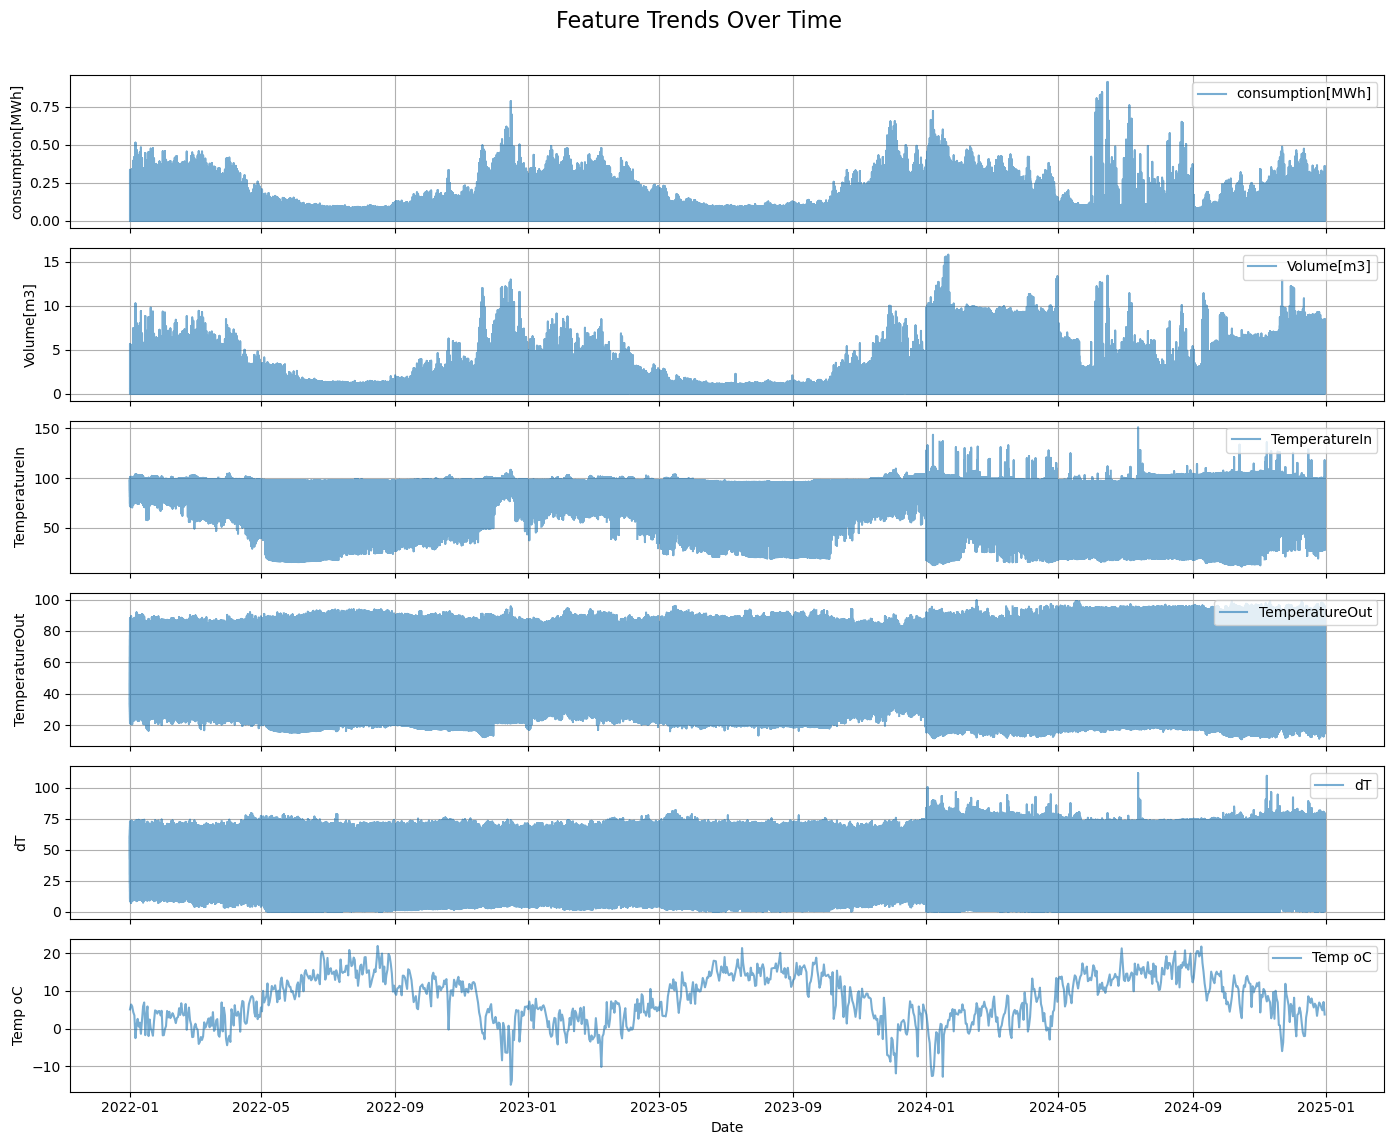

In [4]:
feature_cols = [col for col in full_df.columns if col not in ['source'] and full_df[col].dtype in [float, int]]

# Create subplots for each feature
n_features = len(feature_cols)
fig, axes = plt.subplots(n_features, 1, figsize=(14, 4 * 3), sharex=True)

if n_features == 1:
    axes = [axes]  # Ensure axes is iterable for 1 feature

for i, col in enumerate(feature_cols):
    axes[i].plot(full_df.index, full_df[col], label=col, alpha=0.6)
    axes[i].set_ylabel(col)
    axes[i].legend(loc="upper right")
    axes[i].grid(True)

axes[-1].set_xlabel("Date")
fig.suptitle("Feature Trends Over Time", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

# Train & Test

In [6]:
features = ["consumption[MWh]", "Volume[m3]", "dT","Temp oC"]

In [7]:
def scale_per_building(df, features):
    scalers = {}
    scaled_groups = []

    building_ids = df["source"].unique()

    for source_id in tqdm(building_ids, desc="Scaling buildings"):
        group = df[df["source"] == source_id]
        scaler = MinMaxScaler()
        group_scaled = group.copy()
        group_scaled[features] = scaler.fit_transform(group[features])

        scalers[source_id] = scaler
        scaled_groups.append(group_scaled)

    scaled_df = pd.concat(scaled_groups).sort_index()
    return scaled_df, scalers

In [8]:
def create_windows(df, features):
    df = df[features + ["source"]]
    window_size=7
    
    all_windows = []
    all_sources = []

    for source_id, group in df.groupby("source"):
        group = group.sort_index()  # ensure time order
        dates = group.index
        data = group[features].values

        for i in range(len(group) - window_size + 1):
            start_day = dates[i]
            end_day = dates[i + window_size - 1]

            # Check if the window is strictly Mon to Sun
            if start_day.weekday() == 0 and end_day.weekday() == 6:
                window = data[i:i + window_size]
                flat_window = window.flatten()  # (7x4) → (28,)
                all_windows.append(flat_window)
                all_sources.append(source_id)

    return np.array(all_windows), all_sources

In [9]:
all_buildings = full_df["source"].unique().tolist()
random.seed(42)
test_buildings = random.sample(all_buildings, int(0.1 * len(all_buildings)))

remaining_buildings = list(set(all_buildings) - set(test_buildings))
val_buildings = random.sample(remaining_buildings, int(0.1 * len(all_buildings)))

test_df = full_df[full_df["source"].isin(test_buildings)]
val_df = full_df[full_df["source"].isin(val_buildings)]
train_df = full_df[~full_df["source"].isin(test_buildings + val_buildings)]

print(f"Train buildings: {train_df["source"].nunique()}")
print(f"Validation buildings: {val_df["source"].nunique()}")
print(f"Test buildings: {test_df["source"].nunique()}")


Train buildings: 2928
Validation buildings: 366
Test buildings: 366


In [87]:
2928 +366+366

3660

In [10]:
# Scale per set
scaled_train_df, train_scalers = scale_per_building(train_df, features)
scaled_val_df, val_scalers = scale_per_building(val_df, features)
scaled_test_df, test_scalers = scale_per_building(test_df, features)

Scaling buildings: 100%|█████████████████████| 366/366 [00:01<00:00, 185.56it/s]


In [11]:
# Create windows
train_windows, train_sources = create_windows(scaled_train_df, features)
val_windows, val_sources = create_windows(scaled_val_df, features)
test_windows, test_sources = create_windows(scaled_test_df, features)

In [12]:
print(f"Before clean train windows: {train_windows.shape}")
print(f"Before clean vali windows: {val_windows.shape}")
print(f"Before clean test windows: {test_windows.shape}")
# Remove NaNs
train_mask = ~np.isnan(train_windows).any(axis=1)
val_mask = ~np.isnan(val_windows).any(axis=1)
test_mask = ~np.isnan(test_windows).any(axis=1)

train_windows = train_windows[train_mask]
train_sources = np.array(train_sources)[train_mask]

val_windows = val_windows[val_mask]
val_sources = np.array(val_sources)[val_mask]

test_windows = test_windows[test_mask]
test_sources = np.array(test_sources)[test_mask]

print(f"Cleaned train windows: {train_windows.shape}")
print(f"Cleaned test windows: {val_windows.shape}")
print(f"Cleaned test windows: {test_windows.shape}")


Before clean train windows: (180268, 28)
Before clean vali windows: (22575, 28)
Before clean test windows: (22886, 28)
Cleaned train windows: (176286, 28)
Cleaned test windows: (22137, 28)
Cleaned test windows: (22416, 28)


# Inject Anomalies

In [14]:
def inject_anomalies(windows, sources, types=["amplitude", "mean", "trend"], inject_ratio=0.1,seed=42):
    np.random.seed(seed)
    random.seed(seed)

    modified_windows = windows.copy()
    n_windows = windows.shape[0]
    n_inject = int(n_windows * inject_ratio)

    anomaly_mask = np.zeros(n_windows, dtype=bool)
    anomaly_labels = [None] * n_windows

    selected_indices = random.sample(range(n_windows), n_inject)

    for idx in selected_indices:
        window = modified_windows[idx].copy().reshape(7, 4)
        anomaly_type = random.choice(types)

        injectible_features = [0, 1, 3]
        feature = random.choice(injectible_features)

        if anomaly_type == "amplitude":
            day = random.randint(0, 6)
            window[day, feature] += np.random.uniform(1.5, 3.0)
        elif anomaly_type == "extremum":
            day = random.randint(0, 6)
            window[day, feature] = 1.0 if np.random.rand() > 0.5 else 0.0
        elif anomaly_type == "mean":
            shift = np.random.uniform(0.3, 0.7)
            window[:, feature] += shift
        elif anomaly_type == "trend":
            trend = np.linspace(0, np.random.uniform(0.5, 1.0), 7)
            window[:, feature] += trend
        elif anomaly_type == "platform":
            value = np.mean(window[:, feature])
            window[:, feature] = value
        elif anomaly_type == "pattern":
            base_pattern = np.array([0.2, 0.4, 0.6, 0.4])
            pattern = np.tile(base_pattern, 2)[:7]  # → shape (7,)
            window[:, feature] = pattern
        elif anomaly_type == "pattern_shift":
            pattern = np.sin(np.linspace(0, 2 * np.pi, 7))
            window[:, feature] = np.roll(pattern, np.random.randint(1, 4))
        elif anomaly_type == "variance":
            noise = np.random.normal(0, 0.5, size=7)
            window[:, feature] += noise
        elif anomaly_type == "shift_30":
            shift_factor = random.choice([0.3, -0.3]) 
            window[:, feature] *= (1 + shift_factor)
        elif anomaly_type == "shift_50":
            shift_factor = random.choice([0.5, -0.5]) 
            window[:, feature] *= (1 + shift_factor)
        window = np.clip(window, 0, 1)  #
        modified_windows[idx] = window.flatten()
        anomaly_mask[idx] = True
        anomaly_labels[idx] = anomaly_type
    return modified_windows, anomaly_mask, anomaly_labels


anomaly_types = ["amplitude", "trend", "mean", "platform","pattern", "pattern_shift", "variance", "extremum","shift_30","shift_50"]
anomalous_val_windows, mask, labels = inject_anomalies(val_windows, val_sources, types=anomaly_types, inject_ratio=0.05)
print(f"Injected {mask.sum()} anomalies out of {len(val_windows)} windows.")

Injected 1106 anomalies out of 22137 windows.


# For Deep Traning

In [16]:
temp_train_windows, temp_val_windows, temp_train_sources, temp_val_sources = train_test_split(
    train_windows,
    train_sources,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print(f"Temporary train shape: {temp_train_windows.shape}")
print(f"Temporary val shape: {temp_val_windows.shape}")


Temporary train shape: (141028, 28)
Temporary val shape: (35258, 28)


## USAD

In [18]:
#https://github.com/elisejiuqizhang/USAD-on-WADI-and-SWaT/blob/main/usad.py
def get_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

device = get_default_device()
print(f"Using device: {device}")

def to_device(data, device):
    """Move tensor(s) to the specified device."""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class Encoder(nn.Module):
    def __init__(self, in_size, latent_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size, int(in_size/2))
        self.linear2 = nn.Linear(int(in_size/2), int(in_size/4))
        self.linear3 = nn.Linear(int(in_size/4), latent_size)
        self.relu = nn.ReLU(True)
        
    def forward(self, w):
        out = self.linear1(w)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.relu(out)
        out = self.linear3(out)
        z = self.relu(out)
        return z
    
class Decoder(nn.Module):
    def __init__(self, latent_size, out_size):
        super().__init__()
        self.linear1 = nn.Linear(latent_size, int(out_size/4))
        self.linear2 = nn.Linear(int(out_size/4), int(out_size/2))
        self.linear3 = nn.Linear(int(out_size/2), out_size)
        self.relu = nn.ReLU(True)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, z):
        out = self.linear1(z)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.relu(out)
        out = self.linear3(out)
        w = self.sigmoid(out)
        return w


    
class UsadModel(nn.Module):
    def __init__(self, w_size, z_size):
        super().__init__()
        self.encoder = Encoder(w_size, z_size)
        self.decoder1 = Decoder(z_size, w_size)
        self.decoder2 = Decoder(z_size, w_size)
  
    def training_step(self, batch, n):
        z = self.encoder(batch)
        w1 = self.decoder1(z)
        w2 = self.decoder2(z)
        w3 = self.decoder2(self.encoder(w1))
        loss1 = 1/n*torch.mean((batch - w1)**2) + (1 - 1/n)*torch.mean((batch - w3)**2)
        loss2 = 1/n*torch.mean((batch - w2)**2) - (1 - 1/n)*torch.mean((batch - w3)**2)
        return loss1, loss2

    def validation_step(self, batch, n):
        with torch.no_grad():
            z = self.encoder(batch)
            w1 = self.decoder1(z)
            w2 = self.decoder2(z)
            w3 = self.decoder2(self.encoder(w1))
            loss1 = 1/n*torch.mean((batch - w1)**2) + (1 - 1/n)*torch.mean((batch - w3)**2)
            loss2 = 1/n*torch.mean((batch - w2)**2) - (1 - 1/n)*torch.mean((batch - w3)**2)
        return {"val_loss1": loss1, "val_loss2": loss2}
        
    def validation_epoch_end(self, outputs):
        batch_losses1 = [x["val_loss1"] for x in outputs]
        epoch_loss1 = torch.stack(batch_losses1).mean()
        batch_losses2 = [x["val_loss2"] for x in outputs]
        epoch_loss2 = torch.stack(batch_losses2).mean()
        return {"val_loss1": epoch_loss1.item(), "val_loss2": epoch_loss2.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss1: {:.4f}, val_loss2: {:.4f}".format(epoch, result["val_loss1"], result["val_loss2"]))
    
def evaluate(model, val_loader, n):
    outputs = [model.validation_step(to_device(batch, device), n) for [batch] in val_loader]
    return model.validation_epoch_end(outputs)


def training(epochs, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    models = []
    optimizer1 = opt_func(list(model.encoder.parameters()) + list(model.decoder1.parameters()))
    optimizer2 = opt_func(list(model.encoder.parameters()) + list(model.decoder2.parameters()))
    for epoch in range(epochs):
        for [batch] in train_loader:
            batch = to_device(batch, device)
            
            # Train AE1
            loss1, _loss2 = model.training_step(batch, epoch + 1)
            loss1.backward()
            optimizer1.step()
            optimizer1.zero_grad()
            
            # Train AE2
            _loss1, loss2 = model.training_step(batch, epoch + 1)
            loss2.backward()
            optimizer2.step()
            optimizer2.zero_grad()
            
        result = evaluate(model, val_loader, epoch + 1)
        model.epoch_end(epoch, result)
        history.append(result)

        #my changes
        model_snapshot = {"epoch": epoch + 1,
                          "encoder": copy.deepcopy(model.encoder.state_dict()),
                          "decoder1": copy.deepcopy(model.decoder1.state_dict()),
                          "decoder2": copy.deepcopy(model.decoder2.state_dict())
                         }
        models.append(model_snapshot)

        
    return history, models

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.manual_seed(42)  # optional: can set here too
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

    
def testing(model, test_loader, alpha=0.5, beta=0.5):
    results = []
    with torch.no_grad():
        for [batch] in test_loader:
            batch = to_device(batch, device)
            w1 = model.decoder1(model.encoder(batch))
            w2 = model.decoder2(model.encoder(w1))
            # Compute anomaly score for each sample in the batch
            scores = alpha * torch.mean((batch - w1)**2, axis=1) + beta * torch.mean((batch - w2)**2, axis=1)
            results.append(scores)
    return results

Using device: mps


In [19]:
temp_train_tensor = torch.tensor(temp_train_windows, dtype=torch.float32)
temp_val_tensor = torch.tensor(temp_val_windows, dtype=torch.float32)
temp_train_dataset = data_utils.TensorDataset(temp_train_tensor)
temp_val_dataset = data_utils.TensorDataset(temp_val_tensor)
BATCH_SIZE = 1024
temp_train_loader = data_utils.DataLoader(temp_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
temp_val_loader = data_utils.DataLoader(temp_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [46]:
input_size = temp_train_windows.shape[1]  # 28 =(7 days * 4 features)
latent_size = input_size // 4  # z latent
N_EPOCHS = 7


model = UsadModel(input_size, latent_size).to(device)
model.apply(init_weights)  

start_time = time.time()
history, models = training(N_EPOCHS, model, temp_train_loader, temp_val_loader)



Epoch [0], val_loss1: 0.0129, val_loss2: 0.0128
Epoch [1], val_loss1: 0.0122, val_loss2: -0.0019
Epoch [2], val_loss1: 0.0123, val_loss2: -0.0056
Epoch [3], val_loss1: 0.0154, val_loss2: -0.0100
Epoch [4], val_loss1: 0.0147, val_loss2: -0.0104
Epoch [5], val_loss1: 0.0124, val_loss2: -0.0092
Epoch [6], val_loss1: 0.0161, val_loss2: -0.0130


## Validation

In [453]:
val_tensor = torch.tensor(anomalous_val_windows, dtype=torch.float32)
val_dataset = data_utils.TensorDataset(val_tensor)
val_loader = data_utils.DataLoader(val_dataset, batch_size=1024, shuffle=False)

val_scores = testing(model, val_loader)
val_scores = torch.cat(val_scores).cpu().numpy()

true_labels = np.array(mask, dtype=int)  # 1 = anomaly, 0 = normal

threshold = np.percentile(val_scores, 95)
pred_labels = (val_scores > threshold).astype(int)

val_recall = recall_score(true_labels, pred_labels)
print(f"Validation Recall: {val_recall:.3f}")
val_precision = precision_score(true_labels, pred_labels)
print(f"Validation Precision: {val_precision:.3f}")

Validation Recall: 0.338
Validation Precision: 0.338


## Test

In [494]:
anomalous_test_windows, test_mask, _ = inject_anomalies(test_windows, test_sources, types=anomaly_types, inject_ratio=0.05)

test_tensor = torch.tensor(anomalous_test_windows, dtype=torch.float32)
test_dataset = data_utils.TensorDataset(test_tensor)
test_loader = data_utils.DataLoader(test_dataset, batch_size=1024, shuffle=False)

test_scores = testing(model, test_loader)
test_scores = torch.cat(test_scores).cpu().numpy()


test_labels = np.array(test_mask, dtype=int)
threshold = np.percentile(test_scores, 95)
test_preds = (test_scores > threshold).astype(int)

test_recall = recall_score(test_labels, test_preds)
print(f"Test Recall: {test_recall:.3f}")
test_precision = precision_score(test_labels, test_preds)
print(f"Test Precision: {test_precision:.3f}")


Test Recall: 0.369
Test Precision: 0.368
